# Image Mosaicking with Homography

This notebook demonstrates image mosaicking using homography transformations. We'll:
1. Compute homography matrices from point correspondences
2. Warp images to align them
3. Create seamless mosaics using different blending techniques


## 1. Setup and Imports

Import necessary libraries for image processing, homography computation, and visualization.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## 2. Homography Computation

The homography matrix H maps points from one image plane to another. We use the Direct Linear Transform (DLT) algorithm with SVD to compute H from point correspondences.


In [3]:
def compute_homography(image1points, image2points):
    """
    Computes the homography matrix H that maps points from image1 to image2.
    
    Parameters:
    -----------
    image1points : numpy array of shape (N, 2)
        Points from the first image
    image2points : numpy array of shape (N, 2)
        Corresponding points from the second image
    
    Returns:
    --------
    H : numpy array of shape (3, 3)
        Homography matrix
    """
    # Check that we have at least 4 point correspondences
    n_points = len(image1points)
    if n_points < 4:
        raise ValueError("At least 4 point correspondences are required")
    
    # Build the A matrix for the DLT (Direct Linear Transform) algorithm
    # Each point correspondence gives us 2 equations
    A = np.zeros((2 * n_points, 9))
    
    for i in range(n_points):
        x1, y1 = image1points[i]
        x2, y2 = image2points[i]
        
        # First equation: -x2 = -h11*x1 - h12*y1 - h13 + h31*x1*x2 + h32*y1*x2 + h33*x2
        # Rearranged: h11*x1 + h12*y1 + h13 - h31*x1*x2 - h32*y1*x2 - h33*x2 = 0
        A[2*i, 0] = x1
        A[2*i, 1] = y1
        A[2*i, 2] = 1
        A[2*i, 3] = 0
        A[2*i, 4] = 0
        A[2*i, 5] = 0
        A[2*i, 6] = -x1 * x2
        A[2*i, 7] = -y1 * x2
        A[2*i, 8] = -x2
        
        # Second equation: -y2 = -h21*x1 - h22*y1 - h23 + h31*x1*y2 + h32*y1*y2 + h33*y2
        # Rearranged: h21*x1 + h22*y1 + h23 - h31*x1*y2 - h32*y1*y2 - h33*y2 = 0
        A[2*i+1, 0] = 0
        A[2*i+1, 1] = 0
        A[2*i+1, 2] = 0
        A[2*i+1, 3] = x1
        A[2*i+1, 4] = y1
        A[2*i+1, 5] = 1
        A[2*i+1, 6] = -x1 * y2
        A[2*i+1, 7] = -y1 * y2
        A[2*i+1, 8] = -y2
    
    # Solve using SVD (Total Least Squares approach)
    # We want to find h such that A*h = 0, i.e., h is in the null space of A
    _, _, Vt = np.linalg.svd(A)
    
    # The solution is the last column of V (last row of Vt)
    # This corresponds to the eigenvector with the smallest eigenvalue
    h = Vt[-1, :]
    
    # Reshape to 3x3 matrix
    H = h.reshape(3, 3)
    
    # Normalize the homography matrix (so H[2,2] = 1)
    H = H / H[2, 2]
    
    return H


## 3. Load and Display Images

Load the two images that we want to create a mosaic from.


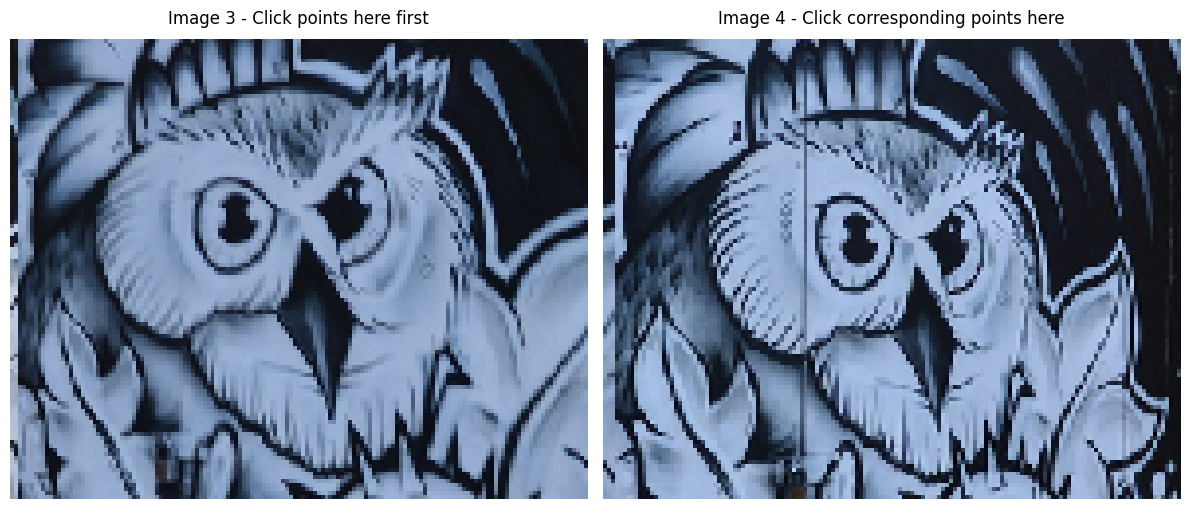

In [4]:
# Load the two images
img1 = plt.imread('image_3.png')
img2 = plt.imread('image_4.png')

# Display both images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].set_title('Image 3 - Click points here first')
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].set_title('Image 4 - Click corresponding points here')
axes[1].axis('off')
plt.tight_layout()
plt.show()


If you haven't selected correspondence points yet, run the cell below to interactively click corresponding points on both images. This will create the `correspondence_points.npz` file that is loaded in the next section.

**Note:** You need to click at least 4 corresponding points on both images. Click them in the same order on both images.


In [ ]:
# Run the click_points.py script to select correspondence points
# This will open interactive windows where you can click points on both images
%run click_points.py


## 4. Load Point Correspondences

Load the correspondence points that were previously selected using the `click_points.py` script (run the cell above if you haven't done this yet). These points define matching features between the two images.


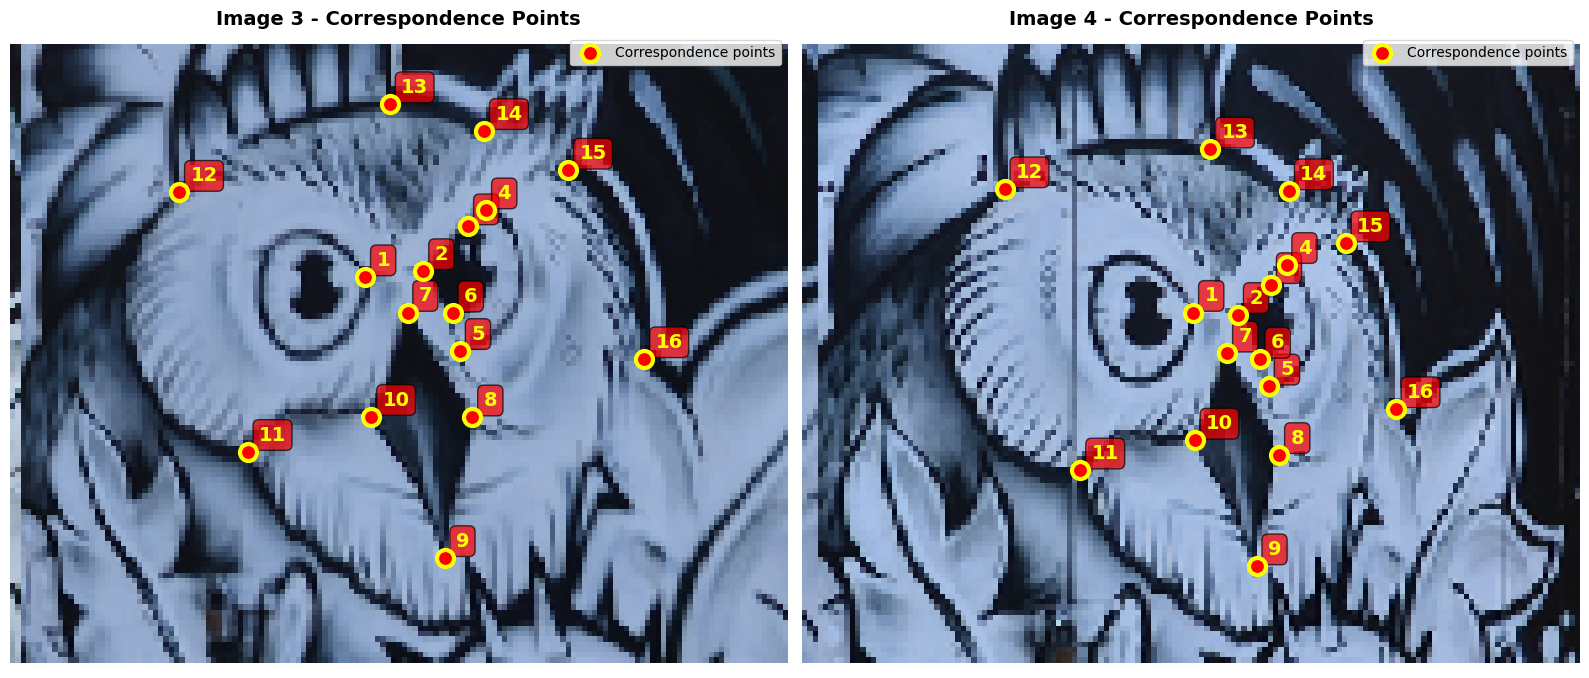

In [5]:
# Load point correspondences from the .npz file
# (Points were collected using the click_points.py script)
data = np.load('correspondence_points.npz')
image1points = data['image1points']
image2points = data['image2points']

# Visualize the correspondence points on both images
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Display Image 3 with points
axes[0].imshow(img1)
axes[0].scatter(image1points[:, 0], image1points[:, 1], c='red', s=150, marker='o', 
                edgecolors='yellow', linewidths=3, label='Correspondence points', zorder=5)
# Add point numbers
for i, point in enumerate(image1points):
    axes[0].annotate(f'{i+1}', (point[0], point[1]), fontsize=14, color='yellow', 
                     weight='bold', xytext=(8, 8), textcoords='offset points',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))
axes[0].set_title('Image 3 - Correspondence Points', fontsize=14, fontweight='bold')
axes[0].axis('off')
axes[0].legend(loc='upper right', fontsize=10)

# Display Image 4 with points
axes[1].imshow(img2)
axes[1].scatter(image2points[:, 0], image2points[:, 1], c='red', s=150, marker='o', 
                edgecolors='yellow', linewidths=3, label='Correspondence points', zorder=5)
# Add point numbers
for i, point in enumerate(image2points):
    axes[1].annotate(f'{i+1}', (point[0], point[1]), fontsize=14, color='yellow', 
                     weight='bold', xytext=(8, 8), textcoords='offset points',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))
axes[1].set_title('Image 4 - Correspondence Points', fontsize=14, fontweight='bold')
axes[1].axis('off')
axes[1].legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()


## 5. Compute Homography Matrix

Compute the homography matrix H that transforms points from Image 3 to Image 4.


In [7]:

# Compute the homography matrix
H = compute_homography(image1points, image2points)


print(H)


[[ 1.62840125e+00  1.28912381e-01 -1.10167151e+01]
 [ 4.76408279e-01  1.45481758e+00 -2.38743775e+01]
 [ 5.26351762e-03  1.52546345e-03  1.00000000e+00]]


## 6. Verify Homography Accuracy

Apply the computed homography to the original points and compare with the target points to measure reprojection error.


In [8]:
# Verify the homography by transforming image1points and comparing with image2points
def apply_homography(points, H):
    """
    Applies homography H to a set of points.
    
    Parameters:
    -----------
    points : numpy array of shape (N, 2)
        Points to transform
    H : numpy array of shape (3, 3)
        Homography matrix
    
    Returns:
    --------
    transformed_points : numpy array of shape (N, 2)
        Transformed points
    """
    # Convert to homogeneous coordinates
    ones = np.ones((len(points), 1))
    points_homogeneous = np.hstack([points, ones])
    
    # Apply homography
    transformed_homogeneous = (H @ points_homogeneous.T).T
    
    # Convert back to Cartesian coordinates
    transformed_points = transformed_homogeneous[:, :2] / transformed_homogeneous[:, 2:3]
    
    return transformed_points


In [9]:

# Transform image1points using the computed homography
transformed_points = apply_homography(image1points, H)

# Compute reprojection error
errors = np.linalg.norm(image2points - transformed_points, axis=1)
mean_error = np.mean(errors)
max_error = np.max(errors)

print(f"Mean reprojection error: {mean_error:.2f} pixels")
print(f"Max reprojection error: {max_error:.2f} pixels")


Mean reprojection error: 0.74 pixels
Max reprojection error: 1.48 pixels


## 7. Image Warping

Warp Image 3 using the computed homography to align it with Image 4.

In [10]:
# Optional: Warp image1 using the homography to align with image2

def warp_image(image, H, output_shape=None):
    """
    Warps an image using a homography matrix.
    
    Parameters:
    -----------
    image : numpy array
        Input image to warp
    H : numpy array of shape (3, 3)
        Homography matrix
    output_shape : tuple (height, width), optional
        Output image shape. If None, uses input image shape.
    
    Returns:
    --------
    warped_image : numpy array
        Warped image
    """
    if output_shape is None:
        h, w = image.shape[:2]
    else:
        h, w = output_shape
    
    # Create coordinate grid
    y_coords, x_coords = np.mgrid[0:h, 0:w]
    
    # Flatten coordinates
    coords = np.stack([x_coords.flatten(), y_coords.flatten(), np.ones(h*w)])
    
    # Apply inverse homography to find source coordinates
    H_inv = np.linalg.inv(H)
    source_coords = (H_inv @ coords).T
    source_coords = source_coords[:, :2] / source_coords[:, 2:3]
    
    # Reshape to image coordinates
    source_x = source_coords[:, 0].reshape(h, w)
    source_y = source_coords[:, 1].reshape(h, w)
    
    # Interpolate pixel values using OpenCV
    if len(image.shape) == 3:
        warped = cv2.remap(image, 
                           source_x.astype(np.float32), 
                           source_y.astype(np.float32),
                           cv2.INTER_LINEAR,
                           borderMode=cv2.BORDER_CONSTANT)
    else:
        warped = cv2.remap(image, 
                           source_x.astype(np.float32), 
                           source_y.astype(np.float32),
                           cv2.INTER_LINEAR,
                           borderMode=cv2.BORDER_CONSTANT)
    
    return warped


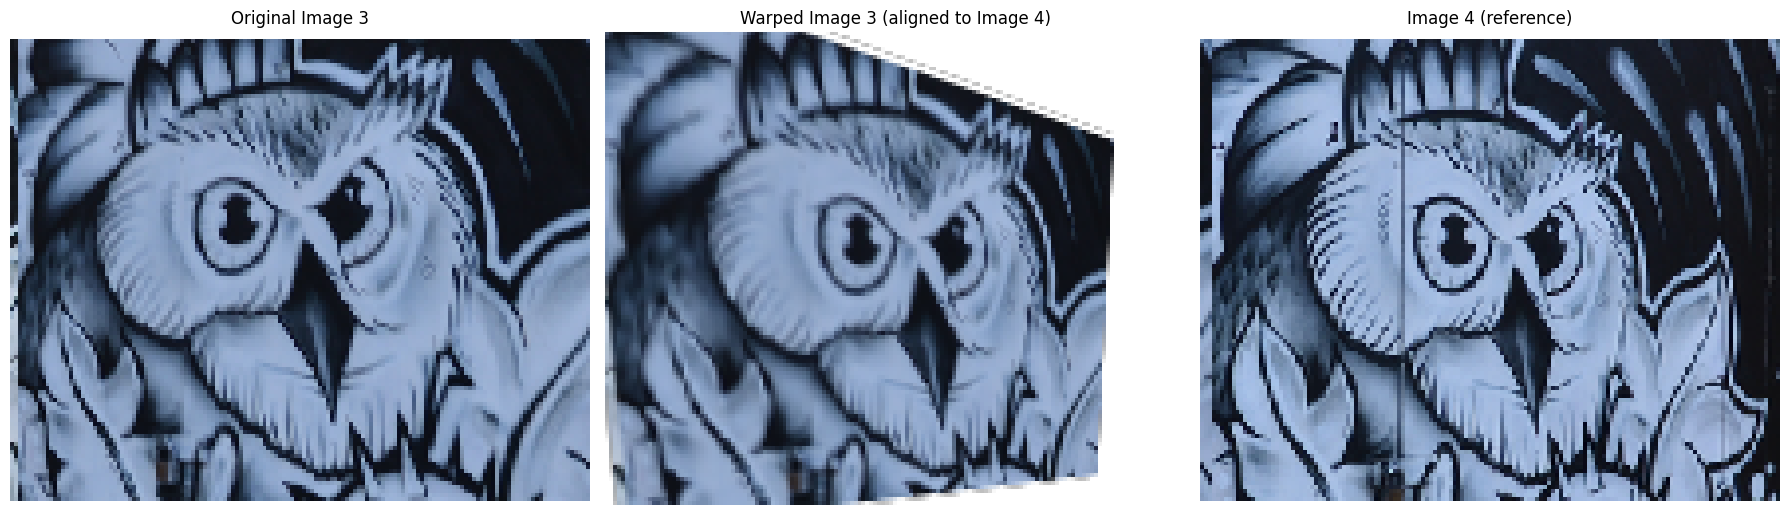

In [11]:

# Warp image1 to align with image2
img1_warped = warp_image(img1, H, output_shape=img2.shape[:2])

# Display results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(img1)
axes[0].set_title('Original Image 3')
axes[0].axis('off')

axes[1].imshow(img1_warped)
axes[1].set_title('Warped Image 3 (aligned to Image 4)')
axes[1].axis('off')

axes[2].imshow(img2)
axes[2].set_title('Image 4 (reference)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [13]:
def compute_mosaic_bbox(images, homographies):
    """
    Computes the bounding box that contains all warped images.
    
    Parameters:
    -----------
    images : list of numpy arrays
        List of input images
    homographies : list of numpy arrays
        List of homography matrices (one per image, or None for unwarped image)
    
    Returns:
    --------
    bbox : tuple (min_x, min_y, max_x, max_y)
        Bounding box coordinates
    offset : tuple (offset_x, offset_y)
        Offset to apply to make coordinates non-negative
    """
    all_corners = []
    
    for img, H in zip(images, homographies):
        h, w = img.shape[:2]
        # Get image corners
        corners = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)
        
        if H is not None:
            # Transform corners using homography
            corners_homogeneous = np.hstack([corners, np.ones((4, 1))])
            transformed = (H @ corners_homogeneous.T).T
            transformed = transformed[:, :2] / transformed[:, 2:3]
            all_corners.append(transformed)
        else:
            all_corners.append(corners)
    
    all_corners = np.vstack(all_corners)
    
    min_x, min_y = np.floor(all_corners.min(axis=0)).astype(int)
    max_x, max_y = np.ceil(all_corners.max(axis=0)).astype(int)
    
    offset_x = -min_x if min_x < 0 else 0
    offset_y = -min_y if min_y < 0 else 0
    
    return (min_x, min_y, max_x, max_y), (offset_x, offset_y)


In [16]:
def create_alpha_mask(shape, feather_width=50):
    """
    Creates an alpha mask with feathering at the edges.
    
    Parameters:
    -----------
    shape : tuple (height, width)
        Shape of the mask
    feather_width : int
        Width of the feathering region in pixels
    
    Returns:
    --------
    alpha : numpy array
        Alpha mask with values between 0 and 1
    """
    h, w = shape
    alpha = np.ones((h, w), dtype=np.float32)
    
    # Create distance maps from edges
    y_coords, x_coords = np.mgrid[0:h, 0:w]
    
    # Distance from each edge
    dist_top = y_coords
    dist_bottom = h - y_coords
    dist_left = x_coords
    dist_right = w - x_coords
    
    # Find minimum distance to any edge
    dist_to_edge = np.minimum(np.minimum(dist_top, dist_bottom),
                              np.minimum(dist_left, dist_right))
    
    # Apply feathering: linear falloff in the feather region
    mask = np.clip(dist_to_edge / feather_width, 0, 1)
    
    return mask


## 8. Mosaic Creation

Create a seamless mosaic by blending the warped images together. We'll use weighted averaging with feathering to create smooth transitions.

**Note:** Make sure to run the cells above (especially Cell 20 with `create_alpha_mask` and `compute_mosaic_bbox`) before running the mosaic creation functions.


In [17]:
def create_mosaic(images, homographies, reference_idx=0, feather_width=50):
    """
    Creates a mosaic by blending multiple images with weighted averaging.
    
    Parameters:
    -----------
    images : list of numpy arrays
        List of input images (can be RGB or RGBA, values in [0, 1] or [0, 255])
    homographies : list of numpy arrays or None
        List of homography matrices for backward mapping (inverse transforms).
        None means the image is not warped.
        If reference_idx is set, that image's homography should be None.
    reference_idx : int
        Index of the reference image (unwarped)
    feather_width : int
        Width of feathering region for blending
    
    Returns:
    --------
    mosaic : numpy array
        Final blended mosaic (uint8, values in [0, 255])
    """
    # Normalize images to [0, 255] range and handle RGBA
    normalized_images = []
    for i, img in enumerate(images):
        # Handle RGBA: convert to RGB by discarding alpha or using alpha blending
        if img.shape[2] == 4:
            # Use RGB channels only (discard alpha)
            img = img[:, :, :3]
        
        # Normalize to [0, 255] range
        # Check if values are in [0, 1] range (allowing for small floating point errors)
        img_max = img.max()
        if img_max <= 1.0 + 1e-6:
            # Values are in [0, 1] range, scale to [0, 255]
            img = (img * 255.0).astype(np.float32)
        else:
            # Values are already in [0, 255] range (or higher), just ensure float32
            img = img.astype(np.float32)
        
        # Ensure values are in [0, 255] range
        img = np.clip(img, 0, 255)
        
        normalized_images.append(img)
    
    images = normalized_images
    # For bbox computation, we need forward transformations (where corners end up)
    # So we invert the homographies if they're provided
    forward_homographies = []
    for H in homographies:
        if H is not None:
            forward_homographies.append(np.linalg.inv(H))
        else:
            forward_homographies.append(None)
    
    # Compute bounding box for the mosaic using forward transformations
    bbox, offset = compute_mosaic_bbox(images, forward_homographies)
    min_x, min_y, max_x, max_y = bbox
    offset_x, offset_y = offset
    
    # Calculate output dimensions
    # The bbox gives us the range, and offset tells us how much to shift
    # Output size = range + 1 (to include both endpoints)
    out_w = int(max_x - min_x + 1)
    out_h = int(max_y - min_y + 1)
    
    # Initialize output arrays (images are now guaranteed to be RGB, 3 channels)
    mosaic = np.zeros((out_h, out_w, 3), dtype=np.float32)
    weight_sum = np.zeros((out_h, out_w), dtype=np.float32)
    
    # Process each image
    for i, (img, H) in enumerate(zip(images, homographies)):
        h, w = img.shape[:2]
        
        # Create coordinate grid for output
        y_coords, x_coords = np.mgrid[0:out_h, 0:out_w]
        
        if H is not None:
            # For warped images: adjust coordinates to get coordinates in output/reference space
            # Then transform to source image space using inverse homography
            x_coords_adj = x_coords - offset_x
            y_coords_adj = y_coords - offset_y
            
            # Transform coordinates using inverse homography (H is already the inverse for backward mapping)
            coords = np.stack([x_coords_adj.flatten(), y_coords_adj.flatten(), np.ones(out_h * out_w)])
            source_coords = (H @ coords).T
            source_coords = source_coords[:, :2] / source_coords[:, 2:3]
            
            source_x = source_coords[:, 0].reshape(out_h, out_w)
            source_y = source_coords[:, 1].reshape(out_h, out_w)
        else:
            # For reference image: it's at (offset_x, offset_y) in the output coordinate system
            # Output coordinate (offset_x, offset_y) corresponds to image coordinate (0, 0)
            # So: image_coord = output_coord - offset
            source_x = x_coords - offset_x
            source_y = y_coords - offset_y
        
        # Create mask for valid pixels (within image bounds)
        valid_mask = (source_x >= 0) & (source_x < w) & (source_y >= 0) & (source_y < h)
        
        # Warp the image (img is now guaranteed to be 3-channel RGB)
        warped = np.zeros((out_h, out_w, 3), dtype=np.float32)
        for c in range(3):
            warped[:, :, c] = cv2.remap(img[:, :, c],
                                        source_x.astype(np.float32),
                                        source_y.astype(np.float32),
                                        cv2.INTER_LINEAR,
                                        borderMode=cv2.BORDER_CONSTANT)
        
        # Create alpha mask with feathering
        alpha = create_alpha_mask((h, w), feather_width)
        
        # Warp the alpha mask
        alpha_warped = cv2.remap(alpha,
                                source_x.astype(np.float32),
                                source_y.astype(np.float32),
                                cv2.INTER_LINEAR,
                                borderMode=cv2.BORDER_CONSTANT)
        
        # Apply valid mask
        alpha_warped = alpha_warped * valid_mask
        
        # Accumulate weighted image (img is now guaranteed to be 3-channel RGB)
        for c in range(3):
            mosaic[:, :, c] += warped[:, :, c] * alpha_warped
        
        weight_sum += alpha_warped
    
    # Normalize by weight sum (avoid division by zero)
    weight_sum = np.maximum(weight_sum, 1e-10)
    for c in range(3):
        mosaic[:, :, c] /= weight_sum
    
    # Convert to uint8 (values should already be in [0, 255] range)
    mosaic = np.clip(mosaic, 0, 255).astype(np.uint8)
    
    return mosaic


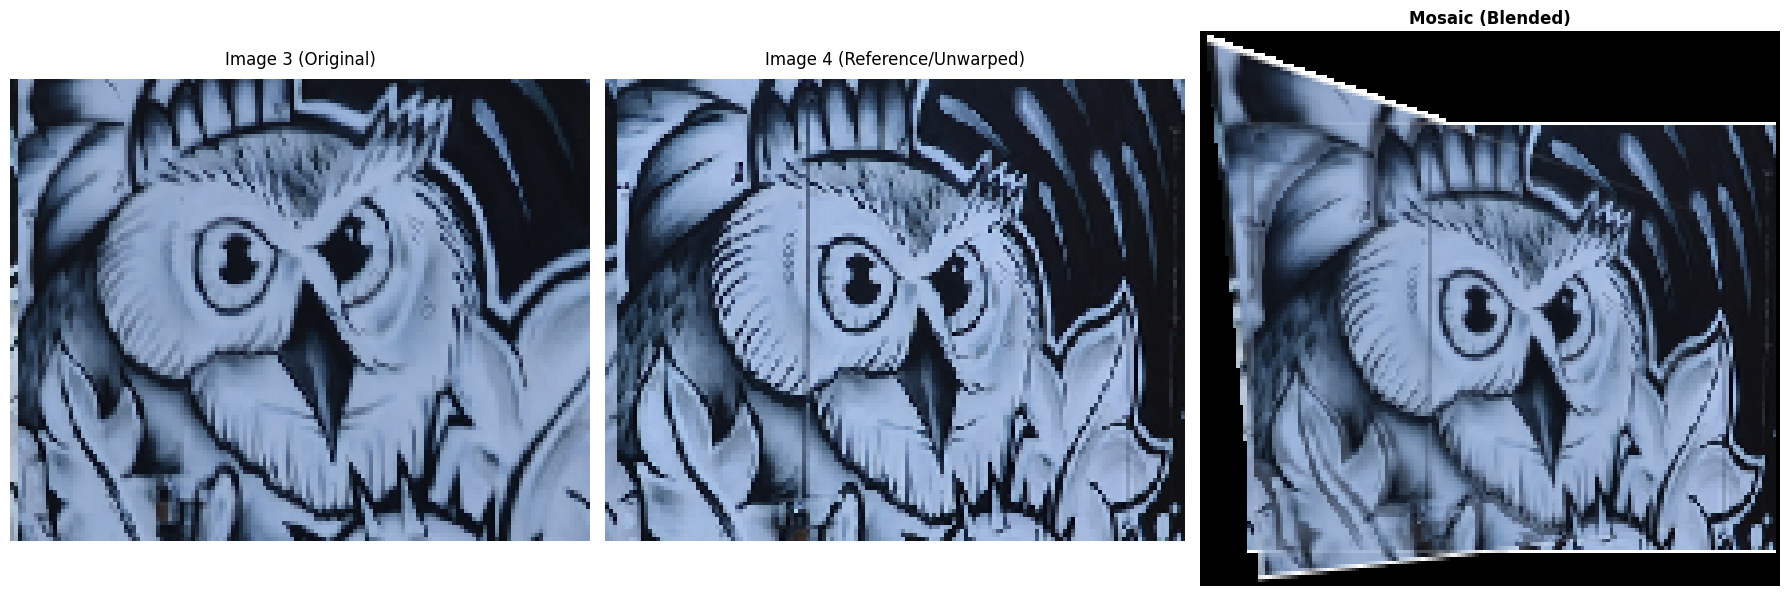

In [18]:
# Create mosaic: Leave image2 unwarped, warp image1 into image2's projection
# We need the inverse homography to warp image1 into image2's space
H_inv = np.linalg.inv(H)

# Create the mosaic
# images: [img1, img2]
# homographies: [H_inv (to warp img1), None (img2 is reference/unwarped)]
mosaic = create_mosaic([img1, img2], [H_inv, None], reference_idx=1, feather_width=50)

# Display the result
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img1)
axes[0].set_title('Image 3 (Original)', fontsize=12)
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title('Image 4 (Reference/Unwarped)', fontsize=12)
axes[1].axis('off')

axes[2].imshow(mosaic)
axes[2].set_title('Mosaic (Blended)', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()


## 8. Laplacian pyramid


In [20]:
def build_gaussian_pyramid(image, levels):
    """
    Build a Gaussian pyramid by repeatedly downsampling the image.
    
    Parameters:
    -----------
    image : numpy array
        Input image
    levels : int
        Number of pyramid levels
    
    Returns:
    --------
    pyramid : list of numpy arrays
        Gaussian pyramid (from finest to coarsest)
    """
    pyramid = [image.astype(np.float32)]
    
    for i in range(levels - 1):
        # Blur and downsample by factor of 2
        blurred = cv2.GaussianBlur(pyramid[-1], (5, 5), 0)
        # Downsample: take every other pixel
        downsampled = blurred[::2, ::2]
        pyramid.append(downsampled)
    
    return pyramid


In [21]:
def build_laplacian_pyramid(gaussian_pyramid):
    """
    Build a Laplacian pyramid from a Gaussian pyramid.
    The Laplacian pyramid contains the difference between levels.
    
    Parameters:
    -----------
    gaussian_pyramid : list of numpy arrays
        Gaussian pyramid
    
    Returns:
    --------
    laplacian_pyramid : list of numpy arrays
        Laplacian pyramid (from finest to coarsest)
    """
    laplacian_pyramid = []
    
    for i in range(len(gaussian_pyramid) - 1):
        # Get current level
        current = gaussian_pyramid[i]
        # Get next (coarser) level
        next_level = gaussian_pyramid[i + 1]
        
        # Upsample the coarser level to match current level size
        h, w = current.shape[:2]
        upsampled = cv2.resize(next_level, (w, h), interpolation=cv2.INTER_LINEAR)
        
        # Laplacian = current - upsampled
        laplacian = current - upsampled
        laplacian_pyramid.append(laplacian)
    
    # The coarsest level is just the Gaussian (no difference to compute)
    laplacian_pyramid.append(gaussian_pyramid[-1])
    
    return laplacian_pyramid


## 9. Laplacian Pyramid Blending

Use Laplacian pyramid blending for higher-quality mosaics. This technique blends images at multiple scales, resulting in smoother transitions and better preservation of detail.


In [22]:
def reconstruct_from_laplacian_pyramid(laplacian_pyramid):
    """
    Reconstruct an image from a Laplacian pyramid.
    
    Parameters:
    -----------
    laplacian_pyramid : list of numpy arrays
        Laplacian pyramid (from finest to coarsest)
    
    Returns:
    --------
    image : numpy array
        Reconstructed image
    """
    # Start with the coarsest level
    image = laplacian_pyramid[-1]
    
    # Reconstruct from coarsest to finest
    for i in range(len(laplacian_pyramid) - 2, -1, -1):
        # Upsample current image
        h, w = laplacian_pyramid[i].shape[:2]
        image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
        # Add the Laplacian detail
        image = image + laplacian_pyramid[i]
    
    return image


In [23]:
def create_mosaic_laplacian(images, homographies, reference_idx=0, levels=5):
    """
    Creates a mosaic using Laplacian pyramid blending for smoother transitions.
    
    Parameters:
    -----------
    images : list of numpy arrays
        List of input images (can be RGB or RGBA, values in [0, 1] or [0, 255])
    homographies : list of numpy arrays or None
        List of homography matrices for backward mapping (inverse transforms).
        None means the image is not warped.
    reference_idx : int
        Index of the reference image (unwarped)
    levels : int
        Number of pyramid levels
    
    Returns:
    --------
    mosaic : numpy array
        Final blended mosaic (uint8, values in [0, 255])
    """
    # Normalize images to [0, 255] range and handle RGBA
    normalized_images = []
    for img in images:
        if img.shape[2] == 4:
            img = img[:, :, :3]
        if img.max() <= 1.0 + 1e-6:
            img = (img * 255.0).astype(np.float32)
        else:
            img = img.astype(np.float32)
        img = np.clip(img, 0, 255)
        normalized_images.append(img)
    images = normalized_images
    
    # Compute bbox
    forward_homographies = []
    for H in homographies:
        if H is not None:
            forward_homographies.append(np.linalg.inv(H))
        else:
            forward_homographies.append(None)
    
    bbox, offset = compute_mosaic_bbox(images, forward_homographies)
    min_x, min_y, max_x, max_y = bbox
    offset_x, offset_y = offset
    out_w = int(max_x - min_x + 1)
    out_h = int(max_y - min_y + 1)
    
    # Warp all images to the output space
    warped_images = []
    masks = []
    
    for i, (img, H) in enumerate(zip(images, homographies)):
        h, w = img.shape[:2]
        
        # Create coordinate grid
        y_coords, x_coords = np.mgrid[0:out_h, 0:out_w]
        
        if H is not None:
            x_coords_adj = x_coords - offset_x
            y_coords_adj = y_coords - offset_y
            coords = np.stack([x_coords_adj.flatten(), y_coords_adj.flatten(), np.ones(out_h * out_w)])
            source_coords = (H @ coords).T
            source_coords = source_coords[:, :2] / source_coords[:, 2:3]
            source_x = source_coords[:, 0].reshape(out_h, out_w)
            source_y = source_coords[:, 1].reshape(out_h, out_w)
        else:
            source_x = x_coords - offset_x
            source_y = y_coords - offset_y
        
        # Create valid mask
        valid_mask = (source_x >= 0) & (source_x < w) & (source_y >= 0) & (source_y < h)
        
        # Warp the image
        warped = np.zeros((out_h, out_w, 3), dtype=np.float32)
        for c in range(3):
            warped[:, :, c] = cv2.remap(img[:, :, c],
                                        source_x.astype(np.float32),
                                        source_y.astype(np.float32),
                                        cv2.INTER_LINEAR,
                                        borderMode=cv2.BORDER_CONSTANT)
        
        warped_images.append(warped)
        masks.append(valid_mask.astype(np.float32))
    
    # Create a smooth blending mask (Gaussian blur of the binary mask)
    # This creates a smooth transition region
    blended_masks = []
    for mask in masks:
        # Apply Gaussian blur to create smooth transitions
        blurred_mask = cv2.GaussianBlur(mask, (51, 51), 0)
        # Normalize so masks sum to 1 where they overlap
        blended_masks.append(blurred_mask)
    
    # Normalize masks so they sum to 1
    mask_sum = sum(blended_masks)
    mask_sum = np.maximum(mask_sum, 1e-10)  # Avoid division by zero
    for i in range(len(blended_masks)):
        blended_masks[i] = blended_masks[i] / mask_sum
    
    # Build Laplacian pyramids for each warped image
    laplacian_pyramids = []
    for warped in warped_images:
        # Process each channel separately
        channel_pyramids = []
        for c in range(3):
            gaussian_pyr = build_gaussian_pyramid(warped[:, :, c], levels)
            laplacian_pyr = build_laplacian_pyramid(gaussian_pyr)
            channel_pyramids.append(laplacian_pyr)
        laplacian_pyramids.append(channel_pyramids)
    
    # Build Gaussian pyramid for the mask
    mask_pyramids = []
    for mask in blended_masks:
        gaussian_pyr = build_gaussian_pyramid(mask, levels)
        mask_pyramids.append(gaussian_pyr)
    
    # Blend Laplacian pyramids using the mask pyramids
    blended_laplacian_pyramids = []
    for c in range(3):
        blended_pyr = []
        for level in range(levels):
            blended_level = np.zeros_like(laplacian_pyramids[0][c][level])
            for i in range(len(laplacian_pyramids)):
                # Blend at this level using the corresponding mask level
                mask_level = mask_pyramids[i][level]
                # Handle different sizes (expand mask if needed)
                if mask_level.shape != laplacian_pyramids[i][c][level].shape:
                    h, w = laplacian_pyramids[i][c][level].shape[:2]
                    mask_level = cv2.resize(mask_level, (w, h), interpolation=cv2.INTER_LINEAR)
                blended_level += laplacian_pyramids[i][c][level] * mask_level
            blended_pyr.append(blended_level)
        blended_laplacian_pyramids.append(blended_pyr)
    
    # Reconstruct the final image from the blended Laplacian pyramids
    mosaic_channels = []
    for c in range(3):
        reconstructed = reconstruct_from_laplacian_pyramid(blended_laplacian_pyramids[c])
        mosaic_channels.append(reconstructed)
    
    # Combine channels
    mosaic = np.stack(mosaic_channels, axis=2)
    
    # Clip and convert to uint8
    mosaic = np.clip(mosaic, 0, 255).astype(np.uint8)
    
    return mosaic


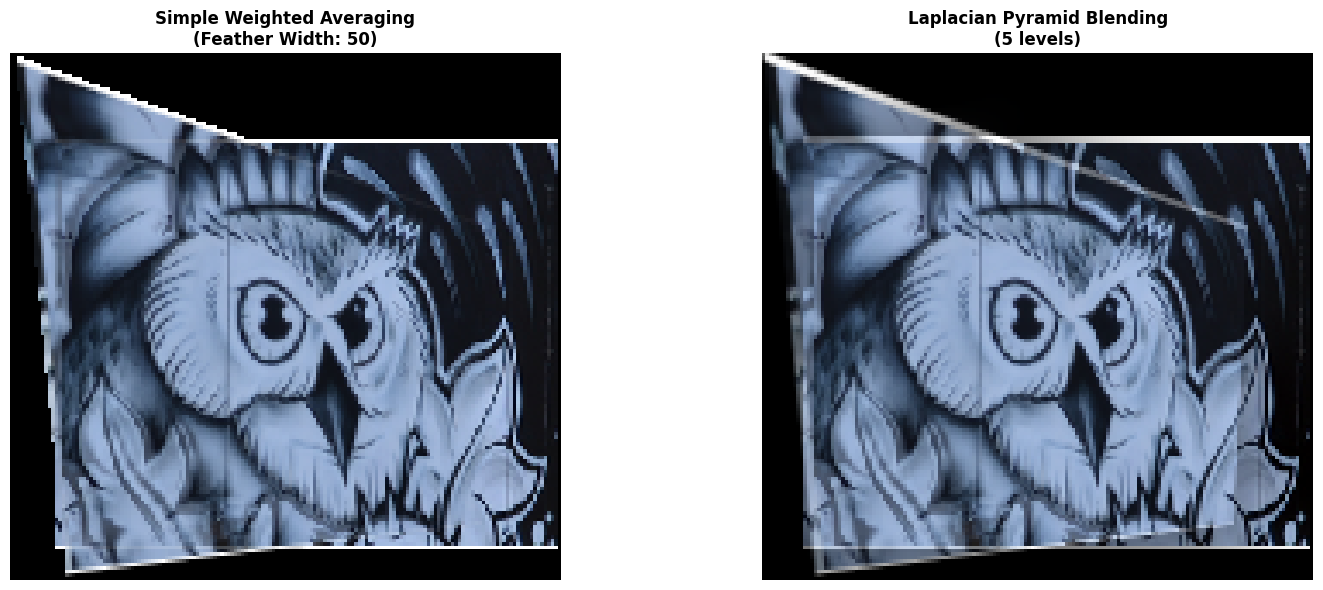

In [24]:
# Create mosaic using Laplacian pyramid blending
mosaic_laplacian = create_mosaic_laplacian([img1, img2], [H_inv, None], reference_idx=1, levels=5)

# Display comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(mosaic)
axes[0].set_title('Simple Weighted Averaging\n(Feather Width: 50)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(mosaic_laplacian)
axes[1].set_title('Laplacian Pyramid Blending\n(5 levels)', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()
